# GMAC Analysis and Optimization Notebook
This notebook contains the entire code for the analysis and optimization of the 
GMAC alorithm using the data collected from a previous study by Dr. Ann David [1].




### Getting the data

If you do not already have the data to run this this notebook, you need to
download it from here.



### Standards modules

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import scipy
from scipy import signal
import pathlib

### Custom Modules

In [3]:
sys.path.append("../scripts")

import classification_algorithms as ca
import reduced_models as rm
import task_analysis as ta

import misc

## Define notebook level constants

In [4]:
# Sampling rate for the data is 50ms
dT = 0.02
Fs = int(1 / dT)
# deltaT = np.timedelta64(int(dT * 1e9), 'ns')

## Read the Controls and Patients Data

In [5]:
# Read healthy and control data
left, right = misc.read_data(subject_type='control')
aff, unaff = misc.read_data(subject_type='patient')

# Assign segments for each subject
left = pd.concat([misc.assign_segments(left[left.subject == subj], dur_th=1, dT=dT)
                  for subj in left.subject.unique()], axis=0)
right = pd.concat([misc.assign_segments(right[right.subject == subj], dur_th=1, dT=dT)
                   for subj in right.subject.unique()])
aff = pd.concat([misc.assign_segments(aff[aff.subject == subj], dur_th=1, dT=dT)
                 for subj in aff.subject.unique()])
unaff = pd.concat([misc.assign_segments(unaff[unaff.subject == subj], dur_th=1, dT=dT)
                   for subj in unaff.subject.unique()])

### Comparing pitch angle from th IMU and just the accelerometer

In [7]:
# Estimation pitch from the accelerometer data for all subjects.
left_pitch_hat = misc.computer_tilt_for_all_subjects(left, accl_lbl='ax', nwin=Fs + 1, causal=True)
right_pitch_hat = misc.computer_tilt_for_all_subjects(right, accl_lbl='ax', nwin=Fs + 1, causal=True)
aff_pitch_hat = misc.computer_tilt_for_all_subjects(aff, accl_lbl='ax', nwin=Fs + 1, causal=True)
unaff_pitch_hat = misc.computer_tilt_for_all_subjects(unaff, accl_lbl='ax', nwin=Fs + 1, causal=True)

### Plot of Pitch from IMU vs. Accelerometer [Healthy Subjects]

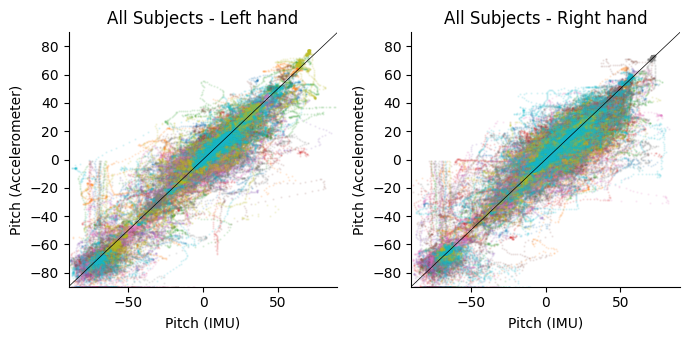

In [8]:
fig = plt.figure(figsize=(7, 3.5))
ax = fig.add_subplot(121)
ax.plot([-90, 90], [-90, 90], lw=0.5, color="k")
for _subj in left.subject.unique():
    left_pitch = left[left.subject == _subj].pitch.values
    ax.scatter(left_pitch, left_pitch_hat[_subj], s=2, marker='.', alpha=0.1)
ax.set_xlim(-90, 90)
ax.set_ylim(-90, 90)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel("Pitch (IMU)")
ax.set_ylabel("Pitch (Accelerometer)")
ax.set_title(f"All Subjects - Left hand")
ax = fig.add_subplot(122)
ax.plot([-90, 90], [-90, 90], lw=0.5, color="k")
for _subj in right.subject.unique():
    right_pitch = right[right.subject == _subj].pitch.values
    ax.scatter(right_pitch, right_pitch_hat[_subj], s=2, marker='.', alpha=0.1)
ax.set_xlim(-90, 90)
ax.set_ylim(-90, 90)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel("Pitch (IMU)")
ax.set_ylabel("Pitch (Accelerometer)")
ax.set_title(f"All Subjects - Right hand")
plt.tight_layout()

### Plot of Pitch from IMU vs. Accelerometer [Stroke Subjects]

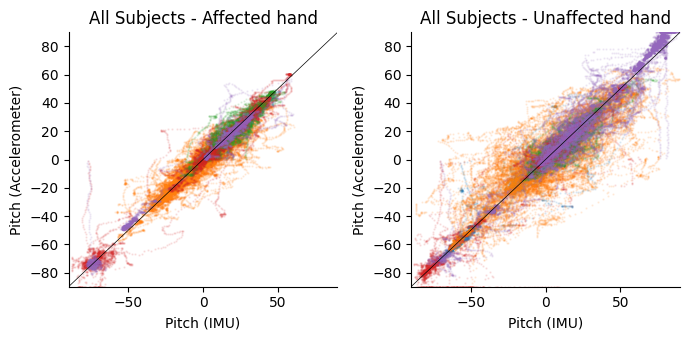

In [9]:
fig = plt.figure(figsize=(7, 3.5))
ax = fig.add_subplot(121)
ax.plot([-90, 90], [-90, 90], lw=0.5, color="k")
for _subj in aff.subject.unique():
    aff_pitch = aff[aff.subject == _subj].pitch.values
    ax.scatter(aff_pitch, aff_pitch_hat[_subj], s=2, marker='.', alpha=0.1)
ax.set_xlim(-90, 90)
ax.set_ylim(-90, 90)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel("Pitch (IMU)")
ax.set_ylabel("Pitch (Accelerometer)")
ax.set_title(f"All Subjects - Affected hand")
ax = fig.add_subplot(122)
ax.plot([-90, 90], [-90, 90], lw=0.5, color="k")
for _subj in unaff.subject.unique():
    unaff_pitch = unaff[unaff.subject == _subj].pitch.values
    ax.scatter(unaff_pitch, unaff_pitch_hat[_subj], s=2, marker='.', alpha=0.1)
ax.set_xlim(-90, 90)
ax.set_ylim(-90, 90)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel("Pitch (IMU)")
ax.set_ylabel("Pitch (Accelerometer)")
ax.set_title(f"All Subjects - Unaffected hand")
plt.tight_layout()

### Compute subjectwise Spearman correlation for pitch

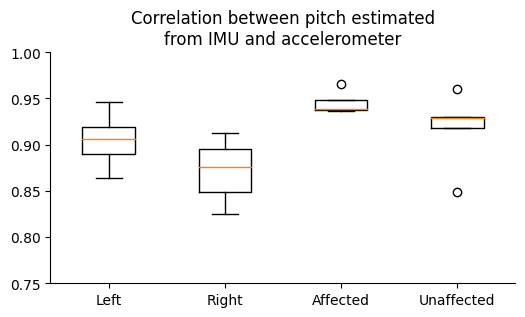

In [10]:
left_corr = [scipy.stats.spearmanr(left[left.subject == _subj].pitch.values,
                                   left_pitch_hat[_subj], nan_policy='omit').correlation
             for _subj in left.subject.unique()]
right_corr = [scipy.stats.spearmanr(right[right.subject == _subj].pitch.values,
                                    right_pitch_hat[_subj], nan_policy='omit').correlation
              for _subj in right.subject.unique()]
aff_corr = [scipy.stats.spearmanr(aff[aff.subject == _subj].pitch.values,
                                  aff_pitch_hat[_subj], nan_policy='omit').correlation for
            _subj in aff.subject.unique()]
unaff_corr = [scipy.stats.spearmanr(unaff[unaff.subject == _subj].pitch.values,
                                    unaff_pitch_hat[_subj], nan_policy='omit').correlation
              for _subj in unaff.subject.unique()]

# Plot the correlation values
fig = plt.figure(figsize=(6, 3))
ax = fig.add_subplot(111)
ax.boxplot([left_corr, right_corr, aff_corr, unaff_corr],
           labels=['Left', 'Right', 'Affected', 'Unaffected'])
ax.set_ylim(0.75, 1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title("Correlation between pitch estimated\nfrom IMU and accelerometer");

### Activity counts from IMU vs. Accelerometer

In [11]:
def compute_accl_magnitude(accl: np.array, nwin: int=50, nfilt: int=5, causal: bool=True) -> np.array:
    """
    Compute the magnitude of the accelerometer signal.
    """
    if causal:
        sos = signal.butter(2, 1/(2*50), 'high', output='sos')
        accl_filt = np.array([signal.sosfilt(sos, accl[:, 0]),
                            signal.sosfilt(sos, accl[:, 1]),
                            signal.sosfilt(sos, accl[:, 2])]).T
    else:
        b, a = signal.butter(2, 1/(2*50), 'high')
        accl_filt = signal.filtfilt(b, a, accl, axis=0)
    
    # Zero low acceleration
    accl_filt[np.abs(accl_filt) < 0.068] = 0
    amag_1 = np.linalg.norm(accl_filt, axis=1)
    amag_1 = np.array([sum(amag_1[i:i + nwin])
                       for i in range(0, len(amag_1), nwin)])
    if causal:
        # moving average filter
        _input = np.append(np.ones(nfilt - 1) * amag_1[0], amag_1)
        return np.convolve(_input, np.ones(nfilt), mode='valid') / nfilt
    else:
        return signal.savgol_filter(amag_1, window_length=nfilt, polyorder=0,
                                    mode='constant')

In [40]:
subj = 1
df = right[right.subject==subj]
act_counts = misc.compute_vector_magnitude(df)
counts = act_counts.counts.values
counts[np.isnan(counts)] = 0
amag = compute_accl_magnitude(df[['ax', 'ay', 'az']].values, nwin=50, nfilt=5,
                              causal=True)

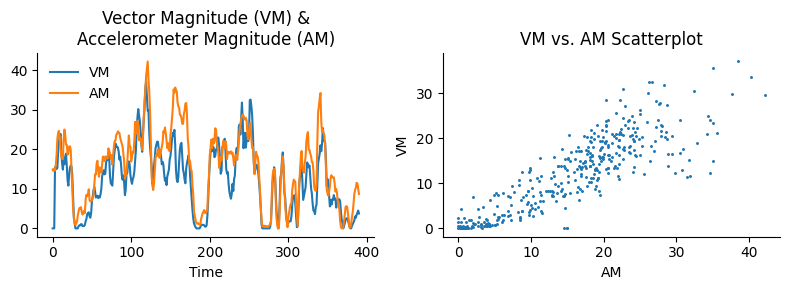

In [43]:
fig = plt.figure(figsize=(8, 3))
ax = fig.add_subplot(121)
ax.plot(0.15 * counts[1:], label="VM")
ax.plot(amag, label="AM")
ax.set_xlabel("Time")
ax.set_title("Vector Magnitude (VM) &\nAccelerometer Magnitude (AM)")
ax.legend(loc=2, frameon=False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax = fig.add_subplot(122)
ax.scatter(amag, 0.15 * counts[1:], s=5, marker='.', alpha=1)
ax.set_xlabel("AM")
ax.set_ylabel("VM")
ax.set_title("VM vs. AM Scatterplot")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tight_layout()

# NEED TO BE FIXED

In [ ]:
left_counts = {}
left_amag = {}
for _subj in left.subject.unique():
    df = left[left.subject==_subj]
    left_counts[_subj] = misc.compute_vector_magnitude(df).counts.values
    left_amag[_subj] = compute_accl_magnitude(df[['ax', 'ay', 'az']].values,
                                              nwin=50, nfilt=5, causal=True)
right_counts = {}
right_amag = {}
for _subj in right.subject.unique():
    df = right[right.subject==_subj]
    right_counts[_subj] = misc.compute_vector_magnitude(df).counts.values
    right_amag[_subj] = compute_accl_magnitude(df[['ax', 'ay', 'az']].values,
                                               nwin=50, nfilt=5, causal=True)
    
aff_counts = {}
aff_amag = {}
for _subj in aff.subject.unique():
    df = aff[aff.subject==_subj]
    aff_counts[_subj] = misc.compute_vector_magnitude(df).counts.values
    aff_amag[_subj] = compute_accl_magnitude(df[['ax', 'ay', 'az']].values,
                                             nwin=50, nfilt=5, causal=True)

unaff_counts = {}
unaff_amag = {}
for _subj in unaff.subject.unique():
    df = unaff[unaff.subject==_subj]
    unaff_counts[_subj] = misc.compute_vector_magnitude(df).counts.values
    unaff_amag[_subj] = compute_accl_magnitude(df[['ax', 'ay', 'az']].values,
                                               nwin=50, nfilt=5, causal=True)

486 486
444 468


ValueError: x and y must be the same size

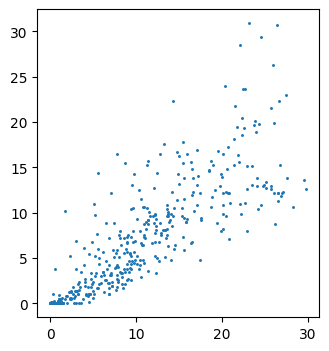

In [42]:
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(121)
for _subj in left.subject.unique():
    print(len(left_amag[_subj]), len(left_counts[_subj][1:]))
    ax.scatter(left_amag[_subj], 0.15 * left_counts[_subj][1:], s=5, marker='.', alpha=1)
ax.set_xlabel("AM")
ax.set_ylabel("VM")
ax.set_title("VM vs. AM Scatterplot")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax = fig.add_subplot(122)
# ax.scatter(amag, 0.15 * counts[1:], s=5, marker='.', alpha=1)
# ax.set_xlabel("AM")
# ax.set_ylabel("VM")
# ax.set_title("VM vs. AM Scatterplot")
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
plt.tight_layout()

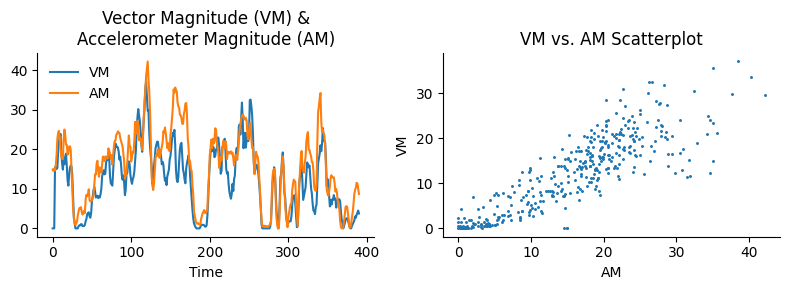

In [33]:
fig = plt.figure(figsize=(8, 3))
ax = fig.add_subplot(121)
ax.plot(0.15 * counts[1:], label="VM")
ax.plot(amag, label="AM")
ax.set_xlabel("Time")
ax.set_title("Vector Magnitude (VM) &\nAccelerometer Magnitude (AM)")
ax.legend(loc=2, frameon=False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax = fig.add_subplot(122)
ax.scatter(amag, 0.15 * counts[1:], s=5, marker='.', alpha=1)
ax.set_xlabel("AM")
ax.set_ylabel("VM")
ax.set_title("VM vs. AM Scatterplot")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tight_layout()

In [133]:
ax = df.ax.values
ay = df.ay.values
az = df.az.values

b, a = signal.butter(2, 1/(2*50), 'high')
ax_filt = signal.filtfilt(b, a, ax)
ay_filt = signal.filtfilt(b, a, ay)
az_filt = signal.filtfilt(b, a, az)

ax_filt[np.abs(ax_filt)<0.068] = 0
ay_filt[np.abs(ay_filt)<0.068] = 0
az_filt[np.abs(az_filt)<0.068] = 0

amag = [np.linalg.norm(x) for x in np.column_stack((ax_filt, ay_filt, az_filt))]
amag = [sum(amag[i:i+nwin]) for i in range(0, len(amag), nwin)]

# moving average filter
w = 5
amag = np.append(np.ones(w-1) * amag[0], amag)
amag = np.convolve(amag, np.ones(w), 'valid') / w

In [134]:
accl = df.loc[:, ['ax', 'ay', 'az']].values
nwin = 50
nfilt = 5

In [148]:
b, a = signal.butter(2, 1/(2*50), 'high')
b, a

(array([ 0.97803048, -1.95606096,  0.97803048]),
 array([ 1.        , -1.95557824,  0.95654368]))

In [167]:
# b, a = signal.butter(2, 1/(2*50), 'high')
# accl_filt = signal.filtfilt(b, a, accl, axis=0)
sos = signal.butter(2, 1/(2*50), 'high', output='sos')
accl_filt = np.array([signal.sosfilt(sos, accl[:, 0]),
                      signal.sosfilt(sos, accl[:, 1]),
                      signal.sosfilt(sos, accl[:, 2])]).T
accl_filt[np.abs(accl_filt) < 0.068] = 0
amag_1 = np.linalg.norm(accl_filt, axis=1)
amag_1 = np.array([sum(amag_1[i:i + nwin])
                   for i in range(0, len(amag_1), nwin)])
# moving average filter
_input = np.append(np.ones(nfilt - 1) * amag_1[0], amag_1)
amag_1 = np.convolve(_input, np.ones(nfilt), mode='valid') / nfilt
# amag_1 = signal.savgol_filter(amag_1, window_length=5, polyorder=0, mode='constant')

In [168]:
print(np.sum(np.abs(ax_filt - accl_filt[:, 0])),
      np.sum(np.abs(ay_filt - accl_filt[:, 1])),
      np.sum(np.abs(az_filt - accl_filt[:, 2])))
print(np.sum(np.abs(amag - amag_1)))

1440.9828367918267 1814.855891568478 1552.8206866837063
311.05980404153706


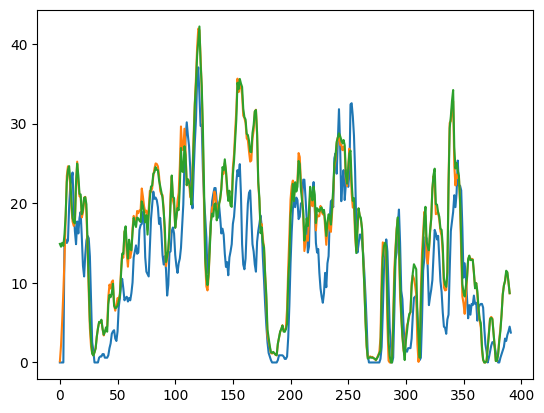

In [169]:
counts = act_counts.counts.values
counts[np.isnan(counts)] = 0
plt.plot(0.15 * counts)
plt.plot(amag)
plt.plot(amag_1)

Text(0, 0.5, 'counts')

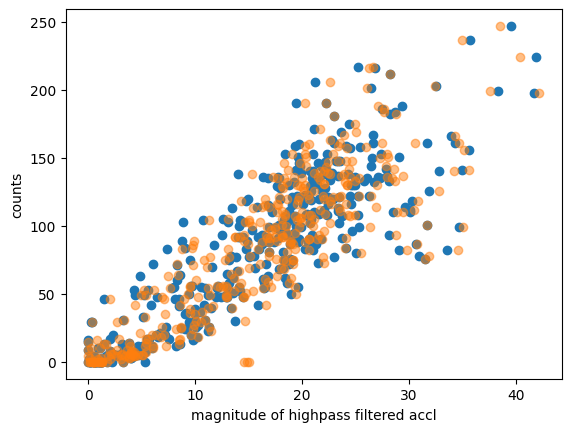

In [170]:
plt.scatter(amag, counts[1:])
plt.scatter(amag_1, counts[1:], alpha=0.5)
plt.xlabel('magnitude of highpass filtered accl')
plt.ylabel('counts')

(0.0, 50.0)

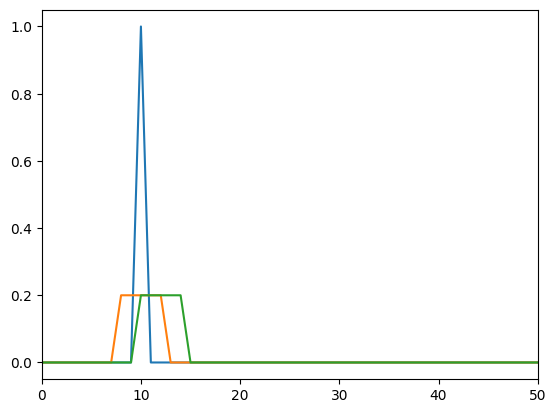

In [110]:
_x = np.zeros(1000)
_x[10] = 1
_y = signal.savgol_filter(_x, window_length=nfilt, polyorder=0, mode='constant')
_y1 = np.append(np.ones(nfilt-1) * _x[0], _x)
_y1 = np.convolve(_y1, np.ones(nfilt), 'valid') / nfilt
plt.plot(_x)
plt.plot(_y)
plt.plot(_y1)
plt.xlim(0, 50)

In [15]:
ax = df.ax.values
ay = df.ay.values
az = df.az.values

b, a = signal.butter(2, 1/(2*50), 'high')
ax_filt = signal.filtfilt(b, a, ax)
ay_filt = signal.filtfilt(b, a, ay)
az_filt = signal.filtfilt(b, a, az)

ax_filt[np.abs(ax_filt)<0.068] = 0
ay_filt[np.abs(ay_filt)<0.068] = 0
az_filt[np.abs(az_filt)<0.068] = 0

amag = [np.linalg.norm(x) for x in np.column_stack((ax_filt, ay_filt, az_filt))]
amag = [sum(amag[i:i+50]) for i in range(0, len(amag), 50)]
w = 5
amag = np.append(np.ones(w-1)*amag[0], amag)

# moving average filter
amag = np.convolve(amag, np.ones(w), 'valid') / w

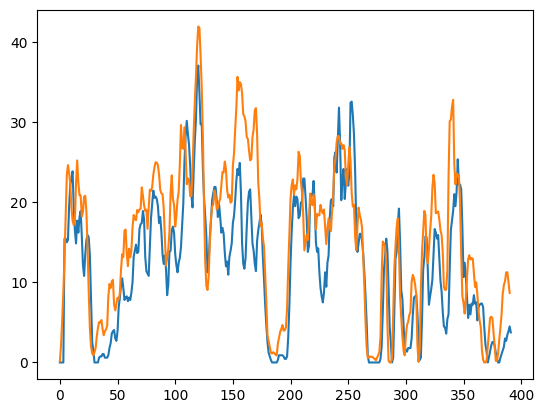

In [16]:
counts = act_counts.counts.values
counts[np.isnan(counts)] = 0
plt.plot(0.15 * counts)
plt.plot(amag)

Text(0, 0.5, 'counts')

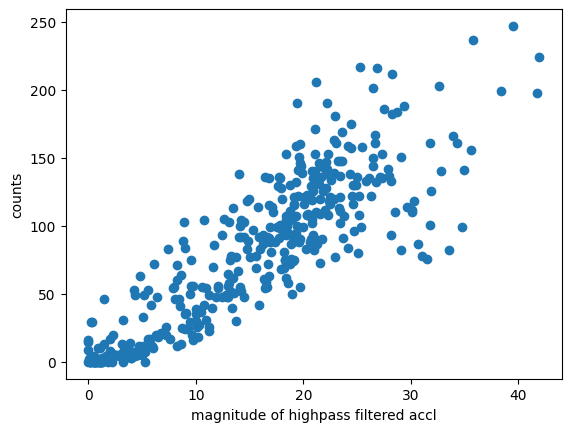

In [17]:
plt.scatter(amag, counts[1:])
plt.xlabel('magnitude of highpass filtered accl')
plt.ylabel('counts')

In [152]:
def compute_vector_magnitude(imudf: pd.DataFrame,
                             accl_lbls:list[str] = ['ax', 'ay', 'az'],
                             gyro_lbls:list[str] = ['gx', 'gy', 'gz']):
    """
    Computes the vector magnitude of the IMU data.
    """
    # Resample each segment at 30Hz.
    df30 = pd.concat([_df[accl_lbls + gyro_lbls + ['segment']].resample('33.33ms').mean()
                      for _, _df in imudf.groupby('segment')])
    print(df30.segment.unique())
    # Output data frame with the vector magnitude counts
    out_df = pd.concat([pd.DataFrame(index=df30.index), df30['segment']],
                       axis=1)

    gyr = np.array(df30[gyro_lbls])
    acc = np.array(df30[accl_lbls])
    g = np.array([0, 0, 1])
    ae = np.empty([len(acc), 3])

    # Madgwick filter
    mg = Madgwick(frequency=30, beta=0.5)
    q = np.tile([1., 0., 0., 0.], (len(acc), 1))

    r = orientation.q2R(mg.updateIMU(q[0], gyr[0], acc[0]))
    ae[0] = np.matmul(r, acc[0]) - g

    for i in range(1, len(acc)):
        q[i] = mg.updateIMU(q[i - 1], gyr[i], acc[i])
        r = orientation.q2R(q[i])
        ae[i] = np.matmul(r, acc[i]) - g

    out_df['ax'] = bandpass(np.nan_to_num(ae[:, 0]), fs=30)
    out_df['ay'] = bandpass(np.nan_to_num(ae[:, 1]), fs=30)
    out_df['az'] = bandpass(np.nan_to_num(ae[:, 2]), fs=30)

    # Resample at 10Hz
    out_df = pd.concat([_df.resample('100ms').mean() for _, _df in out_df.groupby('segment')])
    print(out_df.segment.unique())

    out_df['ax'] = np.where(np.absolute(out_df['ax'].values) < 0.068,
                            0, out_df['ax'].values) / 0.01664
    out_df['ay'] = np.where(np.absolute(out_df['ay'].values) < 0.068,
                            0, out_df['ay'].values) / 0.01664
    out_df['az'] = np.where(np.absolute(out_df['az'].values) < 0.068,
                            0, out_df['az'].values) / 0.01664

    # Resample out_df at 1Hz by summing everything in the 1S window.
    out_df = pd.concat([_df.resample('1S').sum() for _, _df in out_df.groupby('segment')])
    print(out_df.segment.unique())
    out_df['mag'] = [np.linalg.norm(x) for x in np.array(out_df[accl_lbls])]
    out_df['counts'] = [np.round(x) for x in out_df['mag'].rolling(5).mean()]

    return out_df


def bandpass(x, fs=50, order=4):
    sos = signal.butter(order, [0.25, 2.5], 'bandpass', fs=fs, output='sos', analog=False)
    filtered = signal.sosfilt(sos, x)
    return filtered

,counts
time,
2020-03-11 16:21:21,NaN
2020-03-11 16:21:22,NaN
2020-03-11 16:21:23,NaN
2020-03-11 16:21:24,NaN
2020-03-11 16:21:25,103.0
...,...
2020-03-11 17:05:53,18.0
2020-03-11 17:05:54,23.0
2020-03-11 17:05:55,26.0


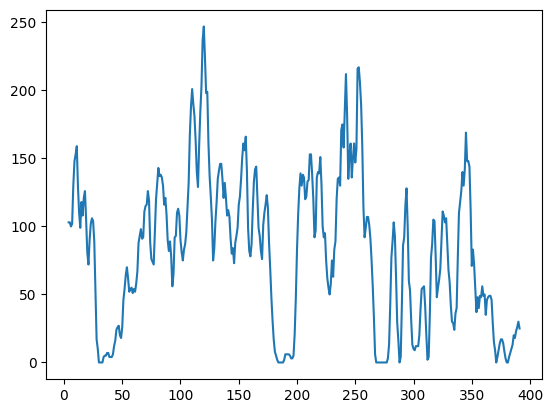

In [10]:
subj = 1
df = right[right.subject==subj]
act_counts = misc.compute_vector_magnitude(df, 30)
plt.plot(act_counts.counts.values)
act_counts

In [11]:
ax = df.ax.values
ay = df.ay.values
az = df.az.values

b, a = signal.butter(2, 1/(2*50), 'high')
ax_filt = signal.filtfilt(b, a, ax)
ay_filt = signal.filtfilt(b, a, ay)
az_filt = signal.filtfilt(b, a, az)

ax_filt[np.abs(ax_filt)<0.068] = 0
ay_filt[np.abs(ay_filt)<0.068] = 0
az_filt[np.abs(az_filt)<0.068] = 0

amag = [np.linalg.norm(x) for x in np.column_stack((ax_filt, ay_filt, az_filt))]
amag = [sum(amag[i:i+50]) for i in range(0, len(amag), 50)]
w = 5
amag = np.append(np.ones(w-1)*amag[0], amag)

# moving average filter
amag = np.convolve(amag, np.ones(w), 'valid') / w

In [193]:
# b, a = signal.butter(2, 1 / 100, 'high')
# accl_df = df[['ax', 'ay', 'az', 'segment']].copy()

# # Filter by segment
# _accldf = pd.DataFrame(
#     np.vstack([signal.filtfilt(b, a, _df[['ax', 'ay', 'az']], axis=0)
#                for _, _df in accl_df.groupby('segment')]), columns=['axf', 'ayf', 'azf'],
#     index=accl_df.index
# )
# accl_df = pd.concat((accl_df, _accldf), axis=1)

# # Zero out the values that are less than 0.068g
# accl_df.loc[accl_df.axf < 0.068, 'axf'] = 0
# accl_df.loc[accl_df.ayf < 0.068, 'ayf'] = 0
# accl_df.loc[accl_df.azf < 0.068, 'azf'] = 0
# accl_df['mag'] = np.linalg.norm(accl_df[['axf', 'ayf', 'azf']], axis=1)

# # Resample accl-df at 1Hz by summuing everything in the 1S window.
# accl_df1 = pd.concat([_df.resample('1S').sum() for _, _df in accl_df.groupby('segment')])
# # accl_df1['magf'] = signal.filtfilt(np.ones(5), [5], accl_df1['mag'])
# [len(_df['mag'].values) for _, _df in accl_df1.groupby('segment')]

# # accl_df1


[347, 1, 1, 43]

In [12]:
accl_df1.segment

NameError: name 'accl_df1' is not defined

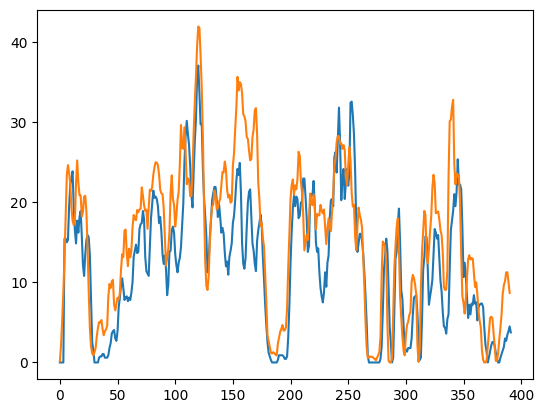

In [14]:
counts = act_counts.counts.values
counts[np.isnan(counts)] = 0
plt.plot(0.15 * counts)
plt.plot(amag)

Text(0, 0.5, 'counts')

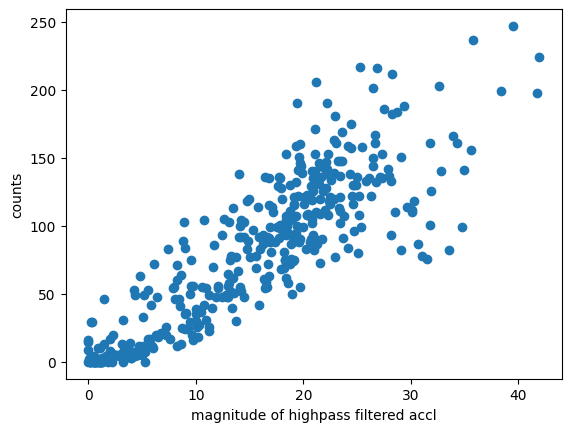

In [15]:
plt.scatter(amag, counts[1:])
plt.xlabel('magnitude of highpass filtered accl')
plt.ylabel('counts')

In [190]:
counts = act_counts.counts.values
counts[np.isnan(counts)] = 0

In [191]:
plt.scatter(accl_df1.magf.values, act_counts.counts.values)
plt.xlabel('magnitude of highpass filtered accl')
plt.ylabel('counts')

AttributeError: 'DataFrame' object has no attribute 'magf'

In [30]:
df = left.loc[left.subject == 1]

In [99]:
# Resample to 30Hz.
accl_lbls = ['ax', 'ay', 'az']
gyro_lbls = ['gx', 'gy', 'gz']

# Resample each segment.
df30 = pd.concat([_df[accl_lbls + gyro_lbls + ['segment']].resample('33.33ms').mean()
                  for _, _df in df.groupby('segment')])

# Output data frame with the vector magnitude counts
out_df = pd.concat([pd.DataFrame(index=df30.index), df30['segment']],
                   axis=1)

gyr = np.array(df30[gyro_lbls])
acc = np.array(df30[accl_lbls])
g = np.array([0, 0, 1])
ae = np.empty([len(acc), 3])

# Madgwick filter
mg = Madgwick(frequency=30, beta=0.5)
q = np.tile([1., 0., 0., 0.], (len(acc), 1))

r = orientation.q2R(mg.updateIMU(q[0], gyr[0], acc[0]))
ae[0] = np.matmul(r, acc[0]) - g

for i in range(1, len(acc)):
    q[i] = mg.updateIMU(q[i - 1], gyr[i], acc[i])
    r = orientation.q2R(q[i])
    ae[i] = np.matmul(r, acc[i]) - g

out_df['ax'] = bandpass(np.nan_to_num(ae[:, 0]), fs=30)
out_df['ay'] = bandpass(np.nan_to_num(ae[:, 1]), fs=30)
out_df['az'] = bandpass(np.nan_to_num(ae[:, 2]), fs=30)

# Resample at 10Hz
out_df = pd.concat([_df.resample('100ms').mean() for _, _df in out_df.groupby('segment')])

out_df['ax'] = np.where(np.absolute(out_df['ax'].values) < 0.068, 0, out_df['ax'].values) / 0.01664
out_df['ay'] = np.where(np.absolute(out_df['ay'].values) < 0.068, 0, out_df['ay'].values) / 0.01664
out_df['az'] = np.where(np.absolute(out_df['az'].values) < 0.068, 0, out_df['az'].values) / 0.01664

# Resample out_df at 1Hz by summing everything in the 1S window.
out_df = pd.concat([_df.resample('1S').sum() for _, _df in out_df.groupby('segment')])
out_df['mag'] = [np.linalg.norm(x) for x in np.array(out_df[accl_lbls])]
out_df['counts'] = [np.round(x) for x in out_df['mag'].rolling(5).mean()]

out_df

,segment,ax,ay,az,mag,counts
time,,,,,,
2020-03-11 16:21:20,0.0,-36.627954,24.222387,-72.052529,84.379488,NaN
2020-03-11 16:21:21,0.0,74.552946,-50.735712,186.102992,206.800817,NaN
2020-03-11 16:21:22,0.0,48.001194,-24.098269,-75.157998,92.377301,NaN
2020-03-11 16:21:23,0.0,-181.507148,119.060462,-160.096856,269.724380,NaN
2020-03-11 16:21:24,0.0,69.022265,-27.368992,121.135861,142.081075,159.0
...,...,...,...,...,...,...
2020-03-11 17:05:53,10.0,-5.883862,9.932025,4.497701,12.389280,19.0
2020-03-11 17:05:54,10.0,-23.781668,19.849946,-1.583785,31.017680,21.0
2020-03-11 17:05:55,10.0,45.548295,-12.845373,-20.033379,51.390535,27.0


In [97]:
out_df

,segment,ax,ay,az
time,,,,
2020-03-11 16:21:20.700,0.0,0.000000,0.000000,0.000000
2020-03-11 16:21:20.800,0.0,-10.832503,7.212207,-22.359860
2020-03-11 16:21:20.900,0.0,-25.795450,17.010180,-49.692669
2020-03-11 16:21:21.000,0.0,-24.907739,16.366625,-41.649926
2020-03-11 16:21:21.100,0.0,-9.829881,6.522451,-6.893339
...,...,...,...,...
2020-03-11 17:05:57.000,1.0,10.645151,5.067441,0.000000
2020-03-11 17:05:57.100,1.0,9.380449,0.000000,0.000000
2020-03-11 17:05:57.200,1.0,0.000000,0.000000,0.000000


In [94]:
out_df

,segment,ax,ay,az
time,,,,
2020-03-11 16:21:20.711340,0.0,-0.001275,0.000860,-0.002782
2020-03-11 16:21:20.744670,0.0,-0.009854,0.006620,-0.021307
2020-03-11 16:21:20.778000,0.0,-0.037024,0.024804,-0.079227
2020-03-11 16:21:20.811330,0.0,-0.092248,0.061658,-0.194892
2020-03-11 16:21:20.844660,0.0,-0.175026,0.116679,-0.363887
...,...,...,...,...
2020-03-11 17:05:57.276990,1.0,-0.021610,0.033188,-0.033579
2020-03-11 17:05:57.310320,1.0,-0.046683,0.043691,-0.016311
2020-03-11 17:05:57.343650,1.0,-0.053513,0.049180,0.010700


,segment,ax,ay,az
time,,,,
2020-03-11 16:21:20.700,0.0,-0.016051,0.010761,-0.034439
2020-03-11 16:21:20.800,0.0,-0.180253,0.120011,-0.372068
2020-03-11 16:21:20.900,0.0,-0.429236,0.283049,-0.826886
2020-03-11 16:21:21.000,0.0,-0.414465,0.272341,-0.693055
2020-03-11 16:21:21.100,0.0,-0.163569,0.108534,-0.114705
...,...,...,...,...
2020-03-11 17:05:57.000,1.0,0.177135,0.084322,0.061616
2020-03-11 17:05:57.100,1.0,0.156091,0.011570,0.008977
2020-03-11 17:05:57.200,1.0,0.022105,0.020116,-0.034101


In [85]:
from ahrs.filters import Mahony, Madgwick
from ahrs.common import orientation


In [87]:
def bandpass(x, fs=50, order=4):
    sos = signal.butter(order, [0.25, 2.5], 'bandpass', fs=fs, output='sos', analog=False)
    filtered = signal.sosfilt(sos, x)
    return filtered

In [89]:
gyr = np.array(df[['gx', 'gy', 'gz']])
acc = np.array(df[['ax', 'ay', 'az']])

g = np.array([0, 0, 1])
ae = np.empty([len(acc), 3])

mg = Madgwick(frequency=30, beta=0.5)
q = np.tile([1., 0., 0., 0.], (len(acc), 1))

r = orientation.q2R(mg.updateIMU(q[0], gyr[0], acc[0]))
ae[0] = np.matmul(r, acc[0]) - g

for i in range(1, len(acc)):
    q[i] = mg.updateIMU(q[i - 1], gyr[i], acc[i])
    r = orientation.q2R(q[i])
    ae[i] = np.matmul(r, acc[i]) - g

op_df['ax'] = bandpass(np.nan_to_num(ae[:, 0]), fs=30)
op_df['ay'] = bandpass(np.nan_to_num(ae[:, 1]), fs=30)
op_df['az'] = bandpass(np.nan_to_num(ae[:, 2]), fs=30)
op_df = resample(op_df, fs, 10)

op_df['ax'] = np.where(np.absolute(op_df['ax'].values) < 0.068, 0, op_df['ax'].values) / 0.01664
op_df['ay'] = np.where(np.absolute(op_df['ay'].values) < 0.068, 0, op_df['ay'].values) / 0.01664
op_df['az'] = np.where(np.absolute(op_df['az'].values) < 0.068, 0, op_df['az'].values) / 0.01664

dfs = get_continuous_segments(op_df)
dfs = [df.resample(str(1) + 'S').sum() for df in dfs]
op_df = pd.concat(dfs)
op_df.index.name = 'time'
op_df = op_df.fillna(0)

op_df['a_mag'] = [np.linalg.norm(x) for x in np.array(op_df[['ax', 'ay', 'az']])]
op_df['counts'] = [np.round(x) for x in op_df['a_mag'].rolling(5).mean()]

NameError: name 'op_df' is not defined

### Fixing issues with resampling

In [154]:
imudf = right[right.subject == 1]
accl_lbls = ['ax', 'ay', 'az']
gyro_lbls = ['gx', 'gy', 'gz']

# Resample each segment at 30Hz.
df30 = pd.concat([_df[accl_lbls + gyro_lbls + ['segment']].resample('33.33ms').mean()
                    for _, _df in imudf.groupby('segment')])
print(df30.segment.unique())
# # Output data frame with the vector magnitude counts
# out_df = pd.concat([pd.DataFrame(index=df30.index), df30['segment']],
#                     axis=1)

# gyr = np.array(df30[gyro_lbls])
# acc = np.array(df30[accl_lbls])
# g = np.array([0, 0, 1])
# ae = np.empty([len(acc), 3])

# # Madgwick filter
# mg = Madgwick(frequency=30, beta=0.5)
# q = np.tile([1., 0., 0., 0.], (len(acc), 1))

# r = orientation.q2R(mg.updateIMU(q[0], gyr[0], acc[0]))
# ae[0] = np.matmul(r, acc[0]) - g

# for i in range(1, len(acc)):
#     q[i] = mg.updateIMU(q[i - 1], gyr[i], acc[i])
#     r = orientation.q2R(q[i])
#     ae[i] = np.matmul(r, acc[i]) - g

# out_df['ax'] = bandpass(np.nan_to_num(ae[:, 0]), fs=30)
# out_df['ay'] = bandpass(np.nan_to_num(ae[:, 1]), fs=30)
# out_df['az'] = bandpass(np.nan_to_num(ae[:, 2]), fs=30)

# # Resample at 10Hz
# out_df = pd.concat([_df.resample('100ms').mean() for _, _df in out_df.groupby('segment')])
# print(out_df.segment.unique())

# out_df['ax'] = np.where(np.absolute(out_df['ax'].values) < 0.068,
#                         0, out_df['ax'].values) / 0.01664
# out_df['ay'] = np.where(np.absolute(out_df['ay'].values) < 0.068,
#                         0, out_df['ay'].values) / 0.01664
# out_df['az'] = np.where(np.absolute(out_df['az'].values) < 0.068,
#                         0, out_df['az'].values) / 0.01664

# # Resample out_df at 1Hz by summing everything in the 1S window.
# out_df = pd.concat([_df.resample('1S').sum() for _, _df in out_df.groupby('segment')])
# print(out_df.segment.unique())
# out_df['mag'] = [np.linalg.norm(x) for x in np.array(out_df[accl_lbls])]
# out_df['counts'] = [np.round(x) for x in out_df['mag'].rolling(5).mean()]

[0. 1.]


In [183]:
df30int = pd.concat([_df[accl_lbls + gyro_lbls + ['segment']].resample('33.33ms').mean()
                    for _, _df in imudf.groupby('segment')])

(18332.681495115277, 18332.681610856016)

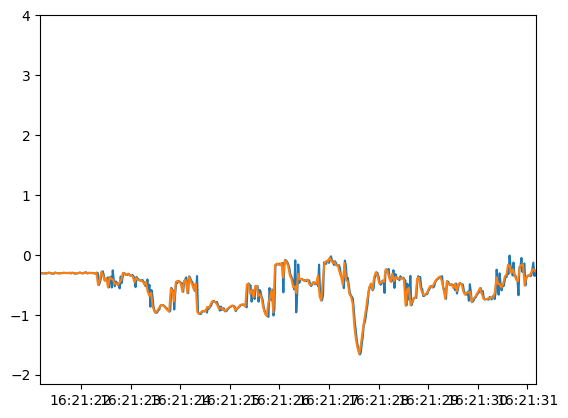

In [187]:
plt.plot(df.ax)
plt.plot(df30.ax)
plt.xlim(df30.index[0], df30.index[0] + pd.Timedelta(seconds=10))

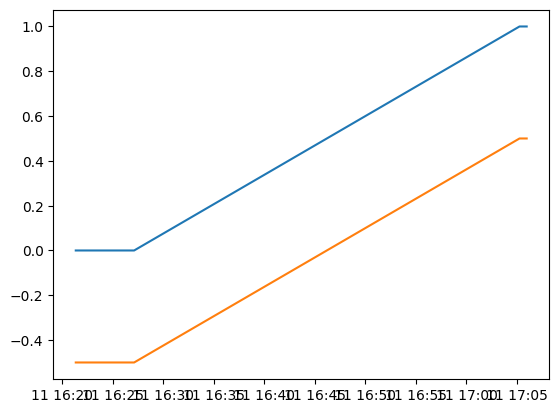

In [189]:
plt.plot(df.segment)
plt.plot(df30.segment - 0.5)

In [164]:
df30

,ax,ay,az,gx,gy,gz,segment
time,,,,,,,
2020-03-11 16:21:21.177960,-0.303955,-0.841553,-0.420654,0.039892,-0.011826,-0.000711,0.0
2020-03-11 16:21:21.211290,-0.308838,-0.846436,-0.419922,0.018607,-0.020606,0.000088,0.0
2020-03-11 16:21:21.244620,-0.311523,-0.833008,-0.423340,0.011690,0.014513,0.007803,0.0
2020-03-11 16:21:21.277950,-0.309814,-0.843750,-0.418457,0.026855,0.016908,0.006473,0.0
2020-03-11 16:21:21.311280,-0.306152,-0.841064,-0.421631,0.017543,0.007596,0.006739,0.0
...,...,...,...,...,...,...,...
2020-03-11 17:05:57.276990,-0.724365,0.058350,-0.377441,0.943535,0.052224,0.050180,1.0
2020-03-11 17:05:57.310320,-1.025635,0.029053,-0.463379,-0.085571,0.124059,0.296017,1.0
2020-03-11 17:05:57.343650,-1.256348,-0.090820,-0.479492,0.453725,-0.007639,0.407494,1.0


In [168]:
df30int

,ax,ay,az,gx,gy,gz,segment
time,,,,,,,
2020-03-11 16:21:21.177960,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-11 16:21:21.211290,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-11 16:21:21.244620,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-11 16:21:21.277950,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-11 16:21:21.311280,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2020-03-11 17:05:57.276990,-0.908203,-0.012695,-0.414062,-0.733419,0.857044,-1.692755,1.0
2020-03-11 17:05:57.310320,-0.908203,-0.012695,-0.414062,-0.733419,0.857044,-1.692755,1.0
2020-03-11 17:05:57.343650,-0.908203,-0.012695,-0.414062,-0.733419,0.857044,-1.692755,1.0


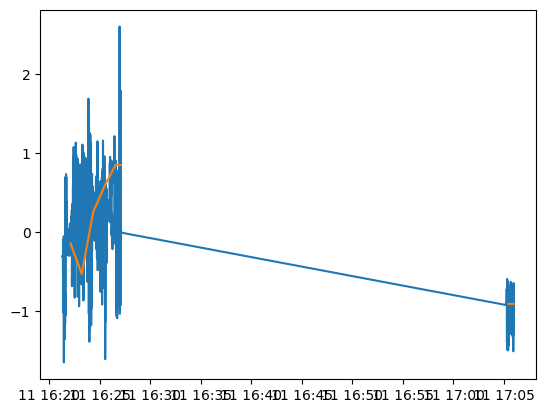

In [105]:
subj = 1
act_counts = ca.compute_vector_magnitude(left[left.subject==1])
act_counts

TypeError: Could not convert 2020-03-11 16:21:19.820 to numeric

In [122]:
b, a = signal.butter(2, 1 / 100, 'high')
accl_df = left[left.subject==1][['ax', 'ay', 'az']].copy()
accl_df['axf'] = signal.filtfilt(b, a, accl_df.ax)
accl_df['ayf'] = signal.filtfilt(b, a, accl_df.ay)
accl_df['azf'] = signal.filtfilt(b, a, accl_df.az)
accl_df['mag'] = np.linalg.norm(accl_df[['axf', 'ayf', 'azf']], axis=1)
accl_dfs = ca.get_continuous_segments(accl_df)
accl_dfs = [_df.resample('1S').sum() for _df in accl_dfs]
accl_df = pd.concat(accl_dfs)
accl_df.index.name = 'time'
accl_df['magf'] = signal.filtfilt(np.ones(5), [5], accl_df['mag'])
accl_df

,ax,ay,az,axf,ayf,azf,mag,magf
time,,,,,,,,
2020-03-11 16:21:20,-10.041016,6.677734,-8.107422,-0.515259,0.057055,0.446759,0.697379,0.697379
2020-03-11 16:21:21,-35.768555,23.598145,-29.249023,-1.755519,-0.825414,1.354829,2.628945,3.840746
2020-03-11 16:21:22,-33.236816,24.530273,-30.769043,-1.353549,-2.269466,-0.764932,6.246481,6.929158
2020-03-11 16:21:23,-26.845215,31.273926,-26.864258,6.707357,5.559086,-3.552876,20.419331,9.189118
2020-03-11 16:21:24,-47.592285,13.443848,-8.319336,-4.842423,-2.869299,3.685287,9.893830,10.155811
...,...,...,...,...,...,...,...,...
2020-03-11 17:05:53,-46.506348,5.153320,-10.225586,2.930203,1.069491,-1.126907,11.466105,11.891263
2020-03-11 17:05:54,-52.203613,0.355469,-5.266602,-3.033626,-2.950416,3.788769,12.004836,11.027022
2020-03-11 17:05:55,-48.233398,7.401367,-14.488770,-1.154359,2.078305,-1.729916,15.739188,9.250503


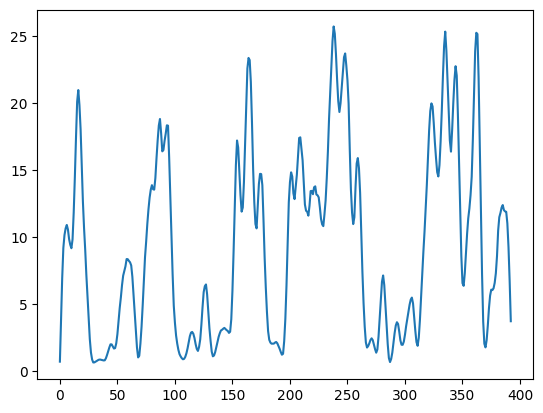

In [129]:
b, a = signal.butter(2, 1/(2*50), 'high')
ax_filt = signal.filtfilt(b, a, ax)
ay_filt = signal.filtfilt(b, a, ay)
az_filt = signal.filtfilt(b, a, az)

ax_filt[np.abs(ax_filt)<0.068] = 0
ay_filt[np.abs(ay_filt)<0.068] = 0
az_filt[np.abs(az_filt)<0.068] = 0

amag = [np.linalg.norm(x) for x in np.column_stack((ax_filt, ay_filt, az_filt))]
amag = [sum(amag[i:i+50]) for i in range(0, len(amag), 50)]
w = 5
amag = np.append(np.ones(w-1)*amag[0], amag)

# moving average filter
amag = np.convolve(amag, np.ones(w), 'valid') / w

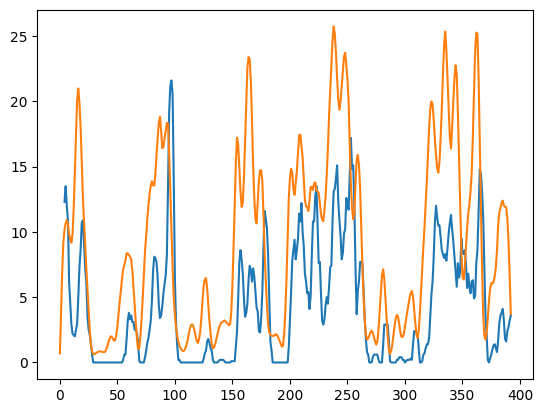

In [131]:
plt.plot(0.1 * act_counts.counts.values)
plt.plot(accl_df.magf.values)

Text(0, 0.5, 'counts')

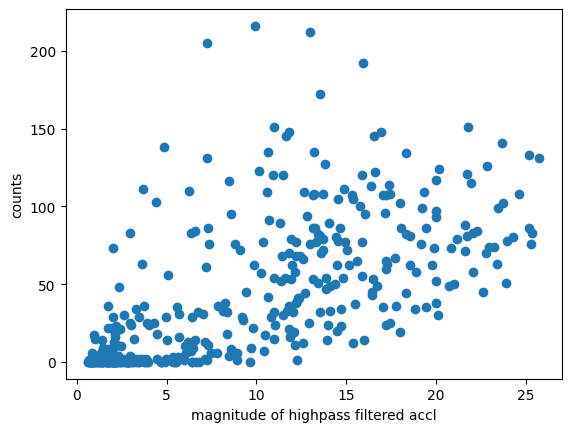

In [123]:
plt.scatter(accl_df.magf, act_counts.counts)
plt.xlabel('magnitude of highpass filtered accl')
plt.ylabel('counts')

In [133]:
import scipy

In [139]:
scipy.stats.spearmanr(accl_df.magf, act_counts.counts, nan_policy='omit')

SignificanceResult(statistic=0.7588786333122322, pvalue=4.390986588166973e-74)

In [81]:
# Compute highpass filtered acceleration magnitude
ax = left[left.subject==1].ax.values
ay = left[left.subject==1].ay.values
az = left[left.subject==1].az.values

In [82]:
print(signal.butter(2, 1/100, 'high', fs=Fs))
print(signal.butter(2, 1/100, 'high'))

(array([ 0.99911182, -1.99822364,  0.99911182]), array([ 1.        , -1.99822285,  0.99822443]))
(array([ 0.97803048, -1.95606096,  0.97803048]), array([ 1.        , -1.95557824,  0.95654368]))


In [83]:
b, a = signal.butter(2, 1 / 100, 'high')
ax_filt = signal.filtfilt(b, a, ax)
ay_filt = signal.filtfilt(b, a, ay)
az_filt = signal.filtfilt(b, a, az)

ax_filt[np.abs(ax_filt) < 0.068] = 0
ay_filt[np.abs(ay_filt) < 0.068] = 0
az_filt[np.abs(az_filt) < 0.068] = 0

amag = [np.linalg.norm(x) for x in np.column_stack((ax_filt, ay_filt, az_filt))]
amag = [sum(amag[i:i + int(Fs)]) for i in range(0, len(amag), int(Fs))]

w = 5
amag = np.append(np.ones(w-1)*amag[0], amag)

# moving average filter
amag = np.convolve(amag, np.ones(w), 'valid') / w

In [112]:
len(mag), len(act_counts)

(2678, 393)

ValueError: x and y must be the same size

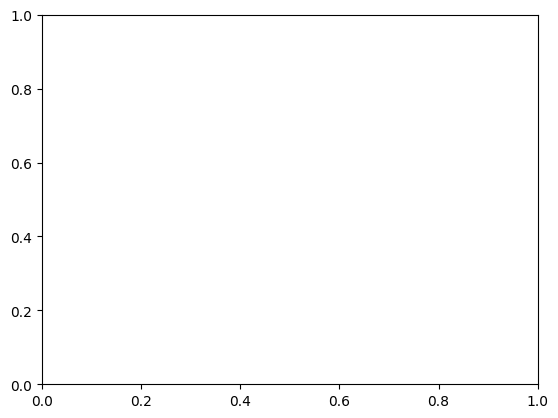

In [17]:
df = left[left.subject==1]
dfs = ca.get_continuous_segments(df)

# df = ca.resample(df, 50, 30)

# op_df = pd.DataFrame(index=df.index)

# gyr = np.array(df[['gx', 'gy', 'gz']])
# acc = np.array(df[['ax', 'ay', 'az']])

# g = np.array([0, 0, 1])
# ae = np.empty([len(acc), 3])

# mg = Madgwick(frequency=30, beta=0.5)
# q = np.tile([1., 0., 0., 0.], (len(acc), 1))

# r = orientation.q2R(mg.updateIMU(q[0], gyr[0], acc[0]))
# ae[0] = np.matmul(r, acc[0]) - g

In [59]:
dfs = [_df.resample(str(round(1 / 30, 3)) + 'S', label='right', closed='right').mean() for _df in dfs]

TypeError: Could not convert 2020-03-11 16:21:19.8202020-03-11 16:21:19.840 to numeric

In [64]:
dfs[0].resample(f"{str(round(1 / 30, 5))}S").sum()

,ax,ay,az,gx,gy,gz,pitch,yaw,mx,my,mz,subject,old_time,r1,r2,g1,g2,task,use_type,gnd
time,,,,,,,,,,,,,,,,,,,,
2020-03-11 16:21:20.711340,-1.398438,0.944824,-1.177734,-0.126001,0.054175,-0.033810,-88.809888,1008.338103,32.030075,161.353383,-68.571429,2,2020-03-11 16:21:19.8202020-03-11 16:21:19.840,0,0,0,0,,,0
2020-03-11 16:21:20.744670,-0.718750,0.473633,-0.584961,-0.092799,0.012454,-0.007859,-43.790383,504.175310,15.939850,80.300752,-33.984962,1,2020-03-11 16:21:19.860,0,0,0,0,,,0
2020-03-11 16:21:20.778000,-1.416504,0.967285,-1.161133,-0.134515,-0.003826,-0.009865,-87.291442,1008.480780,31.127820,160.601504,-69.172932,2,2020-03-11 16:21:19.8802020-03-11 16:21:19.900,0,0,0,0,,,0
2020-03-11 16:21:20.811330,-1.498047,0.959473,-1.121582,-0.010533,-0.034156,-0.023700,-87.239342,1008.692516,30.827068,163.609023,-68.571429,2,2020-03-11 16:21:19.9202020-03-11 16:21:19.940,0,0,0,0,,,0
2020-03-11 16:21:20.844660,-0.725586,0.471191,-0.568848,0.031183,0.021500,-0.034997,-43.868862,504.419153,16.541353,80.601504,-33.984962,1,2020-03-11 16:21:19.960,0,0,0,0,,,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-11 16:27:07.443330,0.005371,0.028809,-1.073730,-0.000743,0.000216,-0.000409,0.308281,519.838714,-29.022556,71.127820,-67.368421,1,2020-03-11 16:27:06.560,0,0,0,0,,,0
2020-03-11 16:27:07.476660,0.011719,0.045410,-2.163574,-0.000423,0.000963,-0.000819,1.191045,1039.675184,-57.293233,139.548872,-133.834586,2,2020-03-11 16:27:06.5802020-03-11 16:27:06.600,0,0,0,0,,,0
2020-03-11 16:27:07.509990,0.010742,0.056641,-2.145508,-0.001487,-0.000101,0.001309,0.345253,1039.670355,-55.939850,136.541353,-135.338346,2,2020-03-11 16:27:06.6202020-03-11 16:27:06.640,0,0,0,0,,,0


In [58]:
dfs[0].index

DatetimeIndex(['2020-03-11 16:21:20.720000', '2020-03-11 16:21:20.740000',
               '2020-03-11 16:21:20.760000', '2020-03-11 16:21:20.780000',
               '2020-03-11 16:21:20.800000', '2020-03-11 16:21:20.820000',
               '2020-03-11 16:21:20.840000', '2020-03-11 16:21:20.860000',
               '2020-03-11 16:21:20.880000', '2020-03-11 16:21:20.900000',
               ...
               '2020-03-11 16:27:07.400000', '2020-03-11 16:27:07.420000',
               '2020-03-11 16:27:07.440000', '2020-03-11 16:27:07.460000',
               '2020-03-11 16:27:07.480000', '2020-03-11 16:27:07.500000',
               '2020-03-11 16:27:07.520000', '2020-03-11 16:27:07.540000',
               '2020-03-11 16:27:07.560000', '2020-03-11 16:27:07.580000'],
              dtype='datetime64[ns]', name='time', length=17344, freq=None)

In [48]:
dfs[0].index

DatetimeIndex(['2020-03-11 16:21:20.720000', '2020-03-11 16:21:20.740000',
               '2020-03-11 16:21:20.760000', '2020-03-11 16:21:20.780000',
               '2020-03-11 16:21:20.800000', '2020-03-11 16:21:20.820000',
               '2020-03-11 16:21:20.840000', '2020-03-11 16:21:20.860000',
               '2020-03-11 16:21:20.880000', '2020-03-11 16:21:20.900000',
               ...
               '2020-03-11 16:27:07.400000', '2020-03-11 16:27:07.420000',
               '2020-03-11 16:27:07.440000', '2020-03-11 16:27:07.460000',
               '2020-03-11 16:27:07.480000', '2020-03-11 16:27:07.500000',
               '2020-03-11 16:27:07.520000', '2020-03-11 16:27:07.540000',
               '2020-03-11 16:27:07.560000', '2020-03-11 16:27:07.580000'],
              dtype='datetime64[ns]', name='time', length=17344, freq=None)

In [47]:
for inx in dfs[0].index:
    print(inx)

2020-03-11 16:21:20.720000
2020-03-11 16:21:20.740000
2020-03-11 16:21:20.760000
2020-03-11 16:21:20.780000
2020-03-11 16:21:20.800000
2020-03-11 16:21:20.820000
2020-03-11 16:21:20.840000
2020-03-11 16:21:20.860000
2020-03-11 16:21:20.880000
2020-03-11 16:21:20.900000
2020-03-11 16:21:20.920000
2020-03-11 16:21:20.940000
2020-03-11 16:21:20.960000
2020-03-11 16:21:20.980000
2020-03-11 16:21:21
2020-03-11 16:21:21.020000
2020-03-11 16:21:21.040000
2020-03-11 16:21:21.060000
2020-03-11 16:21:21.080000
2020-03-11 16:21:21.100000
2020-03-11 16:21:21.120000
2020-03-11 16:21:21.140000
2020-03-11 16:21:21.160000
2020-03-11 16:21:21.180000
2020-03-11 16:21:21.200000
2020-03-11 16:21:21.220000
2020-03-11 16:21:21.240000
2020-03-11 16:21:21.260000
2020-03-11 16:21:21.280000
2020-03-11 16:21:21.300000
2020-03-11 16:21:21.320000
2020-03-11 16:21:21.340000
2020-03-11 16:21:21.360000
2020-03-11 16:21:21.380000
2020-03-11 16:21:21.400000
2020-03-11 16:21:21.420000
2020-03-11 16:21:21.440000
2020-03-

In [28]:
index = pd.date_range('1/1/2000', periods=9, freq='T')
series = pd.Series(range(9), index=index)
series

2000-01-01 00:00:00    0
2000-01-01 00:01:00    1
2000-01-01 00:02:00    2
2000-01-01 00:03:00    3
2000-01-01 00:04:00    4
2000-01-01 00:05:00    5
2000-01-01 00:06:00    6
2000-01-01 00:07:00    7
2000-01-01 00:08:00    8
Freq: T, dtype: int64

In [35]:
series.resample('3T', label="right", closed="right").mean()

2000-01-01 00:00:00    0.0
2000-01-01 00:03:00    2.0
2000-01-01 00:06:00    5.0
2000-01-01 00:09:00    7.5
Freq: 3T, dtype: float64

In [ ]:
b, a = signal.butter(2, 1/(2*50), 'high')
ax_filt = signal.filtfilt(b, a, ax)
ay_filt = signal.filtfilt(b, a, ay)
az_filt = signal.filtfilt(b, a, az)

ax_filt[np.abs(ax_filt)<0.068] = 0
ay_filt[np.abs(ay_filt)<0.068] = 0
az_filt[np.abs(az_filt)<0.068] = 0

amag = [np.linalg.norm(x) for x in np.column_stack((ax_filt, ay_filt, az_filt))]
amag = [sum(amag[i:i+50]) for i in range(0, len(amag), 50)]
w = 5
amag = np.append(np.ones(w-1)*amag[0], amag)

# moving average filter
amag = np.convolve(amag, np.ones(w), 'valid') / w

In [90]:
# Get segmented data for the two arms for controls and patients
left_segdata = misc.get_segmented_data(left, deltaT)
right_segdata = misc.get_segmented_data(right, deltaT)
aff_segdata = misc.get_segmented_data(aff, deltaT)
unaff_segdata = misc.get_segmented_data(unaff, deltaT)

Text(0.5, 1.0, 'Subject 7 - Right Arm')

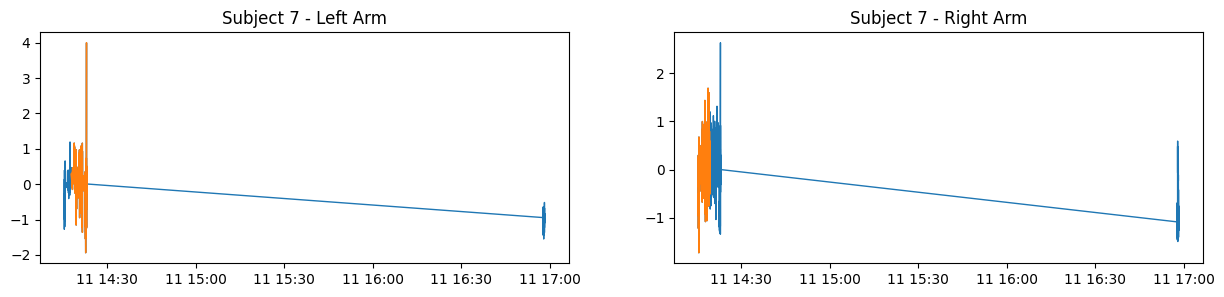

In [126]:
# Generate plots to verify that the data is segmented correctly
subj = 7
fig = plt.figure(figsize=(15, 3))
ax = fig.add_subplot(121)
ax.plot(left[left.subject == subj].index,
        left[left.subject == subj].ax,
        lw=1, label='Left Original')
ax.plot(left_segdata[subj].index,
        left_segdata[subj].ax,
        lw=1, label='Left Segmented')
ax.set_title(f"Subject {subj} - Left Arm")
ax = fig.add_subplot(122)
ax.plot(right[right.subject == subj].index,
        right[right.subject == subj].ax,
        lw=1, label='Right Original')
ax.plot(right_segdata[subj].index,
        right_segdata[subj].ax,
        lw=1, label='Right Segmented')
ax.set_title(f"Subject {subj} - Right Arm")

In [120]:
len(left[left.subject==10])

22317

In [122]:
np.diff(left[left.subject==10].index)[5325:5335]

array([   20000000,    20000000,    20000000,    20000000,    20000000,
          20000000,    20000000, 21020000000,    20000000,    20000000],
      dtype='timedelta64[ns]')

In [123]:
21 * 50

1050

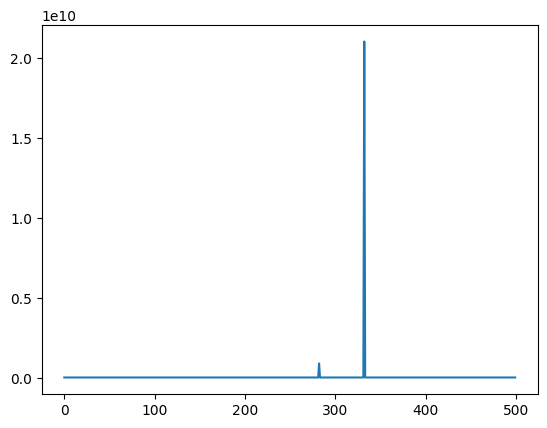

In [121]:
plt.plot(np.diff(left[left.subject==10].index)[5000:5500])


In [116]:
np.diff(left[left.subject==10].index)

array([20000000, 20000000, 20000000, ..., 20000000, 20000000, 20000000],
      dtype='timedelta64[ns]')

In [113]:
5 * deltaT

numpy.timedelta64(100000000,'ns')

In [112]:
misc.get_largest_continuous_segment_indices(left, 10, deltaT)

(5332, 20212)

In [34]:
_inx = np.diff(right[right.subject == 10].index)
np.where(_inx != _inx[0])

(array([ 9394,  9444, 13314, 21004]),)

In [31]:
right.subject.unique()

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10,  1])

# Pitch

In [15]:
def compute_tilt(accl_farm: np.array, nwin: int) -> np.array:
    # Moving averaging using the Savitzky-Golay filter
    af = signal.savgol_filter(accl_farm, window_length=nwin, polyorder=0,
                              mode='costant')
    af[af < -1] = -1
    af[af > 1] = 1
    return -np.rad2deg(np.arccos(af)) + 90

In [35]:
ax = r[r.subject==1].ax.values
pitch_hat = compute_tilt(ax, 50)
pitch = r[r.subject==1].pitch.values

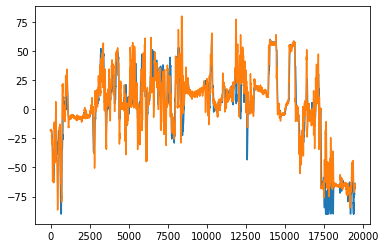

In [11]:
plt.plot(pitch_hat)
plt.plot(pitch)

Text(0, 0.5, 'pitch')

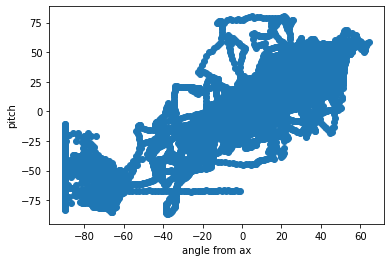

In [12]:
plt.scatter(pitch_hat, pitch)
plt.xlabel('angle from ax')
plt.ylabel('pitch')

In [13]:
pearsonr(pitch, pitch_hat)

(0.9046985706407787, 0.0)

# Activity counts

In [16]:
counts = (ca.compute_vector_magnitude(r[r.subject==1])).counts.values
ay = r[r.subject==1].ay
az = r[r.subject==1].az

In [17]:
b, a = signal.butter(2, 1/(2*50), 'high')
ax_filt = signal.filtfilt(b, a, ax)
ay_filt = signal.filtfilt(b, a, ay)
az_filt = signal.filtfilt(b, a, az)

ax_filt[np.abs(ax_filt)<0.068] = 0
ay_filt[np.abs(ay_filt)<0.068] = 0
az_filt[np.abs(az_filt)<0.068] = 0

amag = [np.linalg.norm(x) for x in np.column_stack((ax_filt, ay_filt, az_filt))]
amag = [sum(amag[i:i+50]) for i in range(0, len(amag), 50)]
w = 5
amag = np.append(np.ones(w-1)*amag[0], amag)

# moving average filter
amag = np.convolve(amag, np.ones(w), 'valid') / w

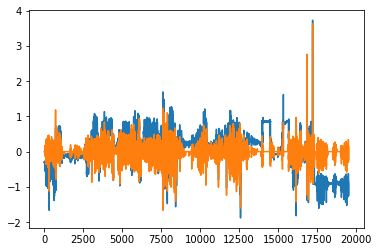

In [18]:
plt.plot(ax)
plt.plot(ax_filt)

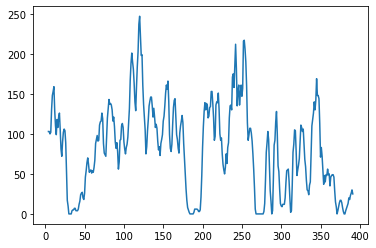

In [19]:
plt.plot(counts)

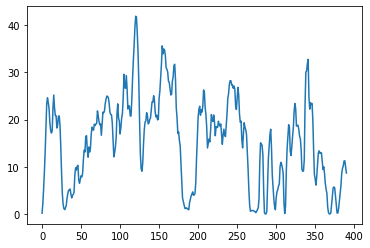

In [20]:
plt.plot(amag)

In [ ]:
counts[np.isnan(counts)] = 0

Text(0, 0.5, 'counts')

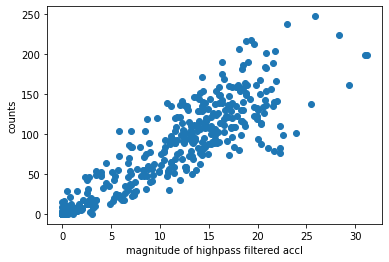

In [ ]:
plt.scatter(amag, counts[1:])
plt.xlabel('magnitude of highpass filtered accl')
plt.ylabel('counts')

In [ ]:
pearsonr(amag, counts[1:])

(0.8822045564601536, 2.618118077333752e-129)

# GMAC

In [36]:
gmac = [1 if np.abs(pitch) < 30 and count > 0 else 0 for pitch, count in zip(pitch_hat[0:len(pitch_hat):50], amag)]
gnd = [r[r.subject==1].gnd[i] for i in range(0, len(r[r.subject==1]), 50)]

In [41]:
ca.confmatrix(gmac, gnd)

,true positive,false positive,false negative,true negative,accuracy,gwets ac1 score,sensitivity,specificity,precision,f1 score,balanced accuracy
0,0.58312,0.120205,0.16624,0.130435,0.713555,0.524543,0.778157,0.520408,0.829091,0.802817,0.649283


In [33]:
gmac_original = (ca.get_gm_modified(r[r.subject==1])).pred.values

In [42]:
ca.confmatrix(gmac_original, gnd[1:])

,true positive,false positive,false negative,true negative,accuracy,gwets ac1 score,sensitivity,specificity,precision,f1 score,balanced accuracy
0,0.54359,0.110256,0.207692,0.138462,0.682051,0.453757,0.723549,0.556701,0.831373,0.773723,0.640125


# optimizing parameters 

In [ ]:
def compute_gmac(ax, ay, az, freq=50, pitch_threshold=30, counts_threshold=0, hpf_cutoff=1, pitch_window=1, counts_window=5):
  w = pitch_window*round(freq)
  ax = np.append(np.ones(w-1)*ax[0], ax)

  # moving average filter
  ax = np.convolve(ax, np.ones(w), 'valid') / w

  ax[ax<-1] = -1
  ax[ax>1] = 1
  pitch = -np.rad2deg(np.arccos(ax))+90

  b, a = signal.butter(2, hpf_cutoff/(2*freq), 'high')
  ax_filt = signal.filtfilt(b, a, ax)
  ay_filt = signal.filtfilt(b, a, ay)
  az_filt = signal.filtfilt(b, a, az)

  deadband_threshold = 0.068
  ax_filt[np.abs(ax_filt)<deadband_threshold] = 0
  ay_filt[np.abs(ay_filt)<deadband_threshold] = 0
  az_filt[np.abs(az_filt)<deadband_threshold] = 0

  amag = [np.linalg.norm(x) for x in np.column_stack((ax_filt, ay_filt, az_filt))]
  amag = [sum(amag[i:i+freq]) for i in range(0, len(amag), freq)]
  w = counts_window
  amag = np.append(np.ones(w-1)*amag[0], amag)

  # moving average filter
  amag = np.convolve(amag, np.ones(w), 'valid') / w

  gmac = [1 if np.abs(pitch) < pitch_threshold and count > counts_threshold else 0 for pitch, count in zip(pitch_hat[0:len(pitch_hat):freq], amag)]
  return gmac